In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from sklearn.cluster import AgglomerativeClustering


In [2]:
data = pd.read_csv(r'Sample_test_attempt_data.csv')

In [3]:
data.head() 

,accuracyRate % (correct/attempted),attemptRate% (attempted/total),studentId,subject
0,0.000000,0.000000,5ace5f3b9fe7b01d581ddef8,Physics
1,0.000000,0.000000,5ace5f3b9fe7b01d581ddef8,Chemistry
2,0.000000,0.000000,5ace5f3b9fe7b01d581ddef8,English
3,0.000000,0.000000,5ace5f3b9fe7b01d581ddef8,Logical Reasoning
4,66.666667,33.333333,5ace5f3b9fe7b01d581ddef8,Mathematics


In [4]:
data.isnull().sum()

accuracyRate % (correct/attempted)    0
attemptRate% (attempted/total)        0
studentId                             0
subject                               0
dtype: int64

In [5]:
data = data.set_index(['studentId']) #setting studentID as index

### Droping studentIds where they have taken exam for only 1 subject as I am assuming that every student has given a fair chance, we can add 0 for other subject but I am just removing them

In [6]:
notid = data.loc[data.groupby(data.index)['subject'].count() < 6].index


In [7]:
data.loc[notid]

,accuracyRate % (correct/attempted),attemptRate% (attempted/total),subject
studentId,,,
5ace53de9fe7b01d581a33c5,75.783476,71.632653,Overall
5ace52c99fe7b01d5819ea30,70.153846,66.326531,Overall
5ace53699fe7b01d581a1406,72.727273,8.979592,Overall
5ace568c9fe7b01d581af7eb,85.714286,17.142857,Overall
5ace4dd29fe7b01d5818adf8,100.000000,2.448980,Overall
5ace5b4e9fe7b01d581c8301,75.132275,38.571429,Overall
5ace5fdd9fe7b01d581e1453,48.051948,15.714286,Overall
5ad45b3b55ce4144f34c5e51,100.000000,0.612245,Overall
5ace56969fe7b01d581afa43,85.436893,42.040816,Overall


In [8]:
data.drop(notid,inplace=True)

### Creating a new feature marks which is derived below. I am assuming there are 100 questions in each subject So, attempt rate gives us the number of question attempted and now using accuracy rate we can find the marks he will obtain for the given subject.

#### *Assuming Overall as a sixth subject

In [9]:
data['marks'] = data['attemptRate% (attempted/total)'] * (data['accuracyRate % (correct/attempted)']/100)

### To handle the repitition of Ids I have taken the mean.

In [10]:
new = data.groupby(['studentId','subject'])['marks'].mean().unstack(level=-1)  #doing same for subjects 


In [11]:
new['Aggregate'] = (np.sum(new,axis=1) / 600) * 100 #percentage of a student using marks

In [12]:
#changing the marks in each subject to values they contribute percentages
for col in  new.columns[:-1]:
    new[col] = (new[col] / 600)*100

In [13]:
new.head() 

subject,Chemistry,English,Logical Reasoning,Mathematics,Overall,Physics,Aggregate
studentId,,,,,,,
5ace4ac29fe7b01d581808f5,0.000000,14.444444,10.000000,0.000000,1.938776,0.000000,26.383220
5ace4ac69fe7b01d581809f1,7.916667,14.444444,16.666667,2.222222,8.605442,12.500000,62.355442
5ace4ac89fe7b01d58180a48,2.083333,12.222222,13.333333,7.407407,5.653333,11.666667,52.366296
5ace4acb9fe7b01d58180acc,11.250000,10.000000,10.000000,11.111111,11.836735,14.583333,68.781179
5ace4acf9fe7b01d58180baa,9.166667,13.333333,10.000000,2.222222,7.993197,10.416667,53.132086


### The reason for calculating percentage for subject was that if a student score high in Maths and does not score well in other subject and if we see aggregate then will assume the score is equally divided between subjects but using this we can say that student is good in math but does not like other subjects. This type of information can be used to create better clusters.

### <a href='https://en.wikipedia.org/wiki/Hierarchical_clustering'>Hierarchical Clustering</a>

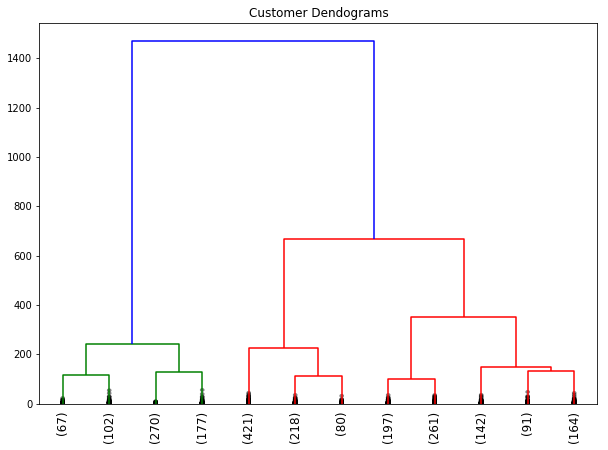

In [14]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(new.values, method='ward')
    ,truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    )  

### Deciding the number of clusters using elbow method which is 4 in this case.

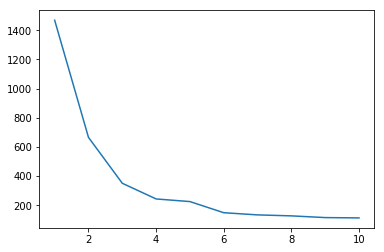

In [15]:
last = shc.linkage(new.values, method='ward')[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)



In [16]:

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
label = cluster.fit_predict(new.values)  

In [17]:
new['cluster'] = label

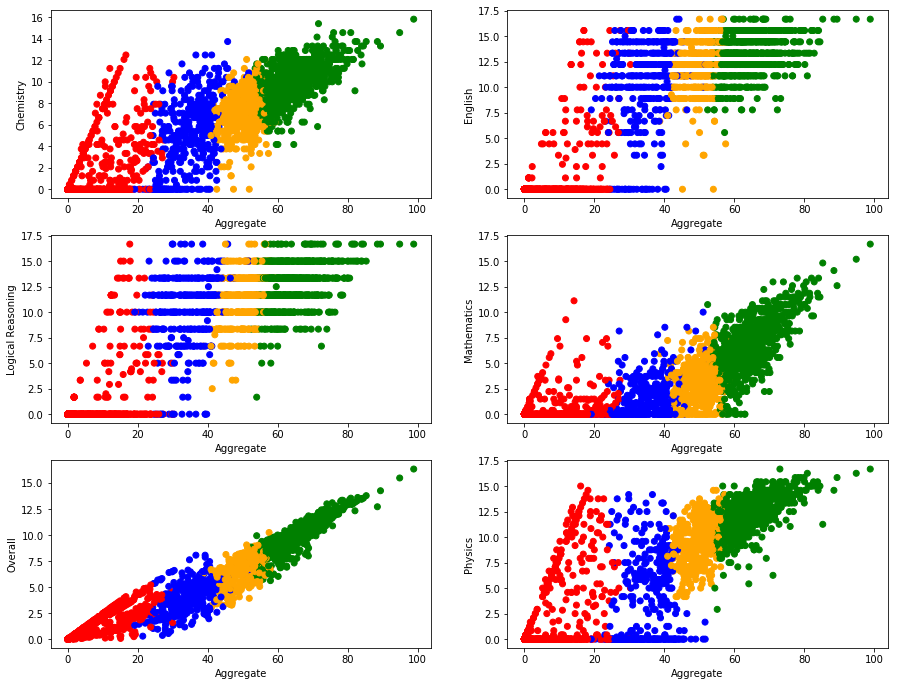

In [19]:
plt.figure(figsize=(15, 20))
colors = {0:'red', 1:'blue', 2:'green', 3:'orange'}
for i,col in enumerate(new.columns[:-2]): 
    plt.subplot(5,2,i+1)
    plt.scatter(new.Aggregate,new[col],c=new['cluster'].apply(lambda x: colors[x]))
    plt.xlabel('Aggregate')
    plt.ylabel(col)

1. No of clusters can be seen as the grades ie A,B,C,D. The green cluster is the one having students with high aggregate.
2. overall have the highest correlation to the aggregate.
3. It is strange to see that high number of students got same marks in English and Logical Reasoning.

### lets plot clusters in 3D

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3) #coverting to 3d for visualising
principalComponents = pca.fit_transform(new.values)
principalDf = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1', 'principal component 2','principal component 3'])

In [23]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plot(x,y,z,color):
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
        size=10,
        color=color,     # set color to an array/list of desired values
        colorscale=[[0, 'rgb(166,2,227)'], [0.25, 'rgb(31,120,180)'], [0.45, 'rgb(178,223,138)'], [0.65, 'rgb(51,160,44)'], [0.85, 'rgb(251,154,153)'], [1, 'rgb(227,26,28)']],   # choose a colorscale
        opacity=0.8
    )
    )

    data = [trace1]
    layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
        )
        )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='3d-scatter-colorscale')

In [25]:
plot(principalDf['principal component 1'],principalDf['principal component 2'],principalDf['principal component 3'],label)

## Lets add total accuracry rate and total attempted rate to data.

In [30]:
ll = pd.concat([new,data.groupby(data.index)['attemptRate% (attempted/total)'].mean()],axis=1)
ll.rename({'attemptRate% (attempted/total)': 'Agg_attempt_rate'},inplace=True)

In [31]:
ll['Agg_accrate'] = ((ll.Aggregate*6) / (ll['attemptRate% (attempted/total)']*6)*100) #total accuracy rate for student

In [32]:
ll.replace([np.inf, -np.inf,np.NaN],0,inplace=True)

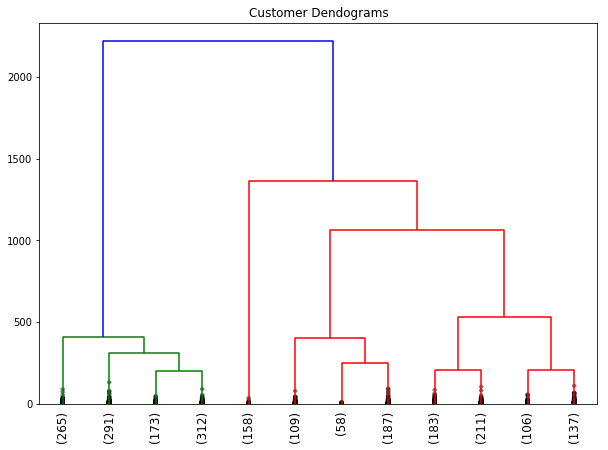

In [33]:
plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(ll.values, method='ward')
    ,truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    )  

#### Five clusters are suggested

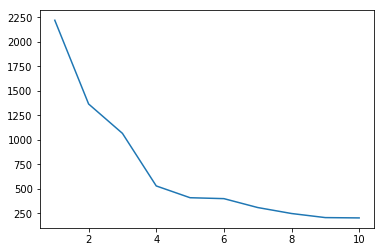

In [34]:
last = shc.linkage(ll.values, method='ward')[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)



In [54]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
l2 = cluster.fit_predict(ll.values)  

In [55]:
ll['cluster'] = l2

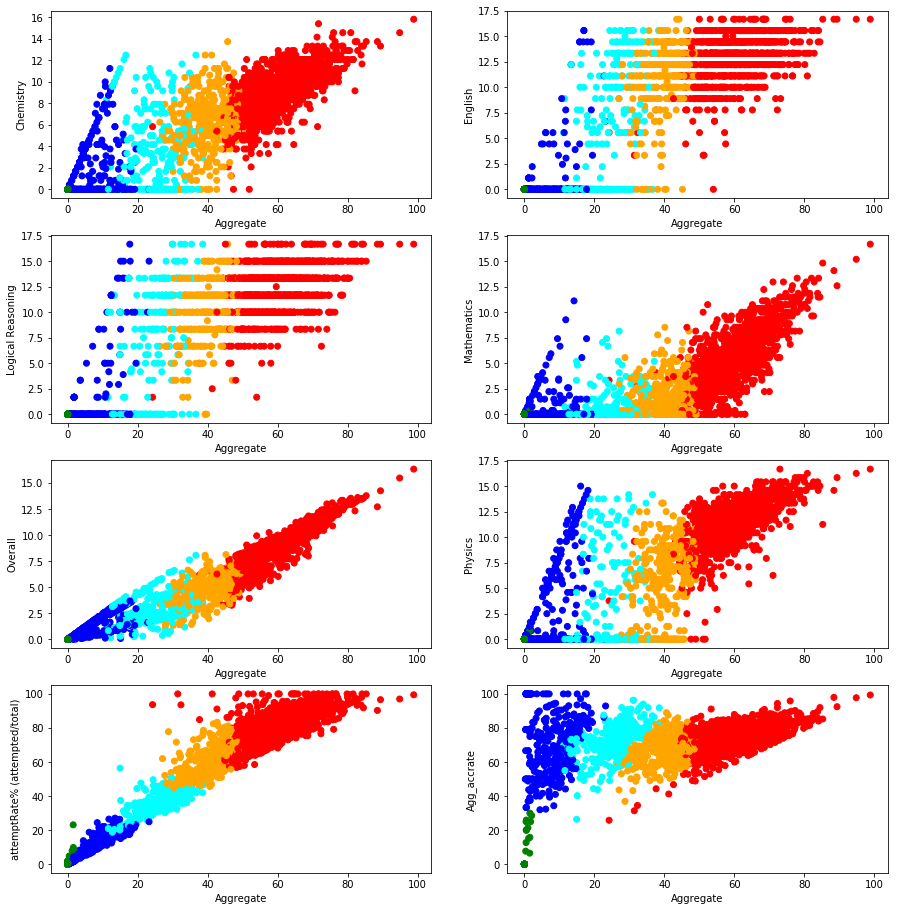

In [60]:
plt.figure(figsize=(15, 20))
colors = {0:'red', 1:'blue', 2:'green', 3:'orange',4:'cyan'}
for i,col in enumerate(ll.drop(['Aggregate','cluster'],axis=1).columns): 
    plt.subplot(5,2,i+1)
    plt.scatter(ll.Aggregate,ll[col],c=ll['cluster'].apply(lambda x: colors[x]))
    plt.xlabel('Aggregate')
    plt.ylabel(col)

In [47]:
pca = PCA(n_components=3) #coverting to 3d for visualising
principalComponents = pca.fit_transform(new.values)
principalDf2 = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1', 'principal component 2','principal component 3'])

In [57]:
plot(principalDf['principal component 1'],principalDf['principal component 2'],principalDf['principal component 3'],l2)

In [62]:
ll[ll.cluster==2].head(15) # cluster havinng lowest count are of those students who performed very poor

,Chemistry,English,Logical Reasoning,Mathematics,Overall,Physics,Aggregate,attemptRate% (attempted/total),Agg_accrate,cluster
studentId,,,,,,,,,,
5ace4af79fe7b01d5818163f,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,2
5ace4afb9fe7b01d58181702,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.518707,0.000000,2
5ace4b9e9fe7b01d58184189,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,1.768707,0.000000,2
5ace4bf69fe7b01d58185a0a,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,2
5ace4c029fe7b01d58185d6d,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,1.105442,0.000000,2
5ace4c0d9fe7b01d58185f68,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,2
5ace4d299fe7b01d58188d34,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.518707,0.000000,2
5ace4e269fe7b01d5818c26e,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.518707,0.000000,2
5ace4ed29fe7b01d5818ee90,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,2


Thankyou